In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import mysql.connector
import os

In [107]:
load_dotenv()
mysqluser = os.getenv("mysqluser")
mysqlpassword = os.getenv("mysqlpassword")
mysqlhost = os.getenv("mysqlhost")
mysqldatabase = os.getenv("mysqldatabase")

Original data from https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

First we downloaded the excel file from the UCI ML repo.  The sheets were then downloaded as csv and split by sheet (one for 2009-2010, the other for 2010-2011)

Next we read in these csv files to pandas dataframes, add a flag to show the original sheet, combine them, and begin data cleaning.  The flag is for checking if issues occured in reading in the csv or if they were present in the original data.  Can be removed after cleaning.


In [108]:
df1 = pd.read_csv(r"data/online_retail_II_2009_2010.csv", encoding='unicode_escape', parse_dates=['InvoiceDate'])
df1['Flag'] = 1
df2 = pd.read_csv(r"data/online_retail_II_2010_2011.csv", encoding='unicode_escape', parse_dates=['InvoiceDate'])
df2['Flag'] = 2
df = pd.concat([df1, df2])
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Flag
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   Flag         1067371 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 81.4+ MB


In [110]:
df.columns = df.columns.str.strip().str.lower()  # Strip leading/trailing whitespace and lowercase all column names
df.rename(columns={"customer id":"customerid"}, inplace=True)  # remove whitespace in customer ID as well
df.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customerid', 'country', 'flag'],
      dtype='object')

Invoice must remain as str because of ones such as 'C489449'.  
Similarly, stockcode must remain as str.  
customerid is converted to Int64 which allows for the NaN values (int alone doesn't)

In [111]:
df.customerid[0]

0    13085.0
0    17850.0
Name: customerid, dtype: float64

The df contains 1067371 entries.  All Invoices must be non-null.  We saw that there exist nulls in Description and Customer ID.  In fact, 22% of our customer id's are missing!  This could be because other rows in the df are already tied to a customer ID by the invoice.  Should group by and examine.

In [112]:
df.isnull().sum()

invoice             0
stockcode           0
description      4382
quantity            0
invoicedate         0
price               0
customerid     243007
country             0
flag                0
dtype: int64

We can also see that there exist negative quantities of products sold and prices.  

<AxesSubplot:>

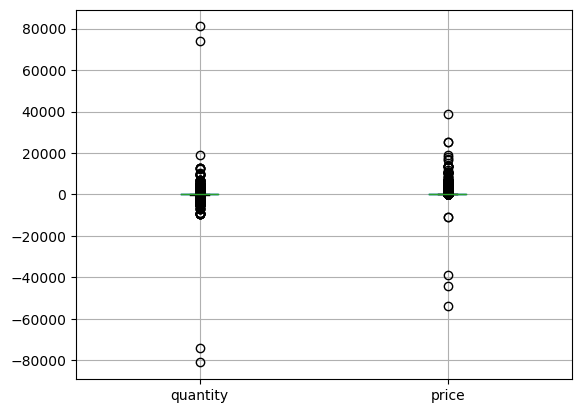

In [113]:
df.boxplot(column=['quantity', 'price'])

In [114]:
print(f"{len(df[df.quantity <=0]) / len(df) * 100:.2f}% of our quantities are negative") 
print(f"{len(df[df.price <=0]) / len(df) * 100:.2f}% of our quantities are negative") 

2.15% of our quantities are negative
0.58% of our quantities are negative


I can't think of a reason for quantities or prices to be negative, and it is a relatively small amount, so we will drop these rows as junk data.

In [115]:
df = df[df.quantity >= 0]  # Get rid of zero or negative quantity orders
df = df[df.price >= 0]  # Get rid of zero or negative price orders

In [119]:
testdf = df.set_index(['invoice', 'customerid'])

In [128]:
df[df.customerid.isna()]

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,1
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,1
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,1
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,1
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,2
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom,2


In [149]:
238796/5000

47.7592

In [150]:
5000/238796

0.020938374177121896

Below cell shows bucket empty

In [158]:
# Takes a long time to run
# i = 0
# bucket = []
# for inv in df[df.customerid.isna()].invoice:
#     if i % 5000 == 0:
#         print(f"{i/238796*100}% Done")
#     if len(df[(df.invoice == inv) & ~(df.customerid.isna())]) > 0:
#         print(inv)
#         bucket.append(inv)
#     i += 1
# bucket

[]

In [143]:
df[(df.invoice == '489525') & ~(df.customerid.isna())]
len(df[(df.invoice == '489525') & (df.customerid.isna())])

2

In [159]:
# df[df.invoice == '489548']

# Possible Business Questions
- What is our most commonly sold item?
- What is our total revenue?
- When did we sell the most?
- How do our sales trends look? Look at # sales over time, revenue over time, revenue by country, etc.
- Where do we sell the most?
- Where is most profitable to sell?

## Other:
should add sql commands for updating our data for future use with python connector.  

https://stackoverflow.com/questions/1081750/python-update-multiple-columns-with-python-variables

https://stackoverflow.com/questions/33495194/mysql-insert-on-duplicate-update-for-non-primary-key